# Data Engineering

After the visualization process, we have to organize the data before applyinng the Machine Learning algorithms. Therefore, we shall handle missing data, data transformations, feature extraction, and feature selection. 

Load the necessary libraries and the data. 

In [1]:
# When Google Colab is being used 

#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import os
import tqdm

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.impute import KNNImputer, SimpleImputer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Definitions for the notebook

In [12]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

%matplotlib inline

## Importing the dataset

In [37]:
# For local folder
location = "../data/"
# For Google colab
location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p1.csv", index_col = 0)
air_data.Data = pd.to_datetime(air_data.Data) 
air_data.head()

,Data,year,month,day,hour,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,CO,O3,PM10
326721,2011-01-01 00:30:00+00:00,2011,1,1,0,7,-22.898,-43.222,0.0,1009.60,2.87,26.66,90.73,180.00,0.47,0.03,8.47,8.00
387058,2011-01-01 00:30:00+00:00,2011,1,1,0,8,-22.925,-43.233,0.0,1007.45,6.40,20.91,89.49,176.83,2.92,0.13,5.08,44.05
103079,2011-01-01 00:30:00+00:00,2011,1,1,0,3,-22.908,-43.178,0.2,1009.33,1.57,21.81,84.50,250.67,0.34,0.17,17.89,10.00
163229,2011-01-01 00:30:00+00:00,2011,1,1,0,1,-22.965,-43.180,0.0,1009.52,0.70,24.09,79.79,157.00,0.90,0.15,3.68,34.64
387059,2011-01-01 01:30:00+00:00,2011,1,1,1,8,-22.925,-43.233,0.0,1006.57,6.50,20.53,92.83,211.17,2.82,0.13,11.90,55.89


Removing the pandemic years. 

In [39]:
air_data = air_data[air_data.year < 2020]

## Feature extraction: seasonal and time variables

We add variables in order to help the estimates. We are putting season 0 (summer) to months January, February, and March, for instance. After, we need to ajust the months March, June, September, and December, because each one is divided between two seasons.

In [40]:
air_data["weekend"] = air_data.Data.dt.weekday >= 5
air_data["season"] = (air_data.month - 1)// 3
air_data.season += (air_data.month == 3)&(air_data.day>=20)
air_data.season += (air_data.month == 6)&(air_data.day>=21)
air_data.season += (air_data.month == 9)&(air_data.day>=23)
air_data.season += (air_data.month == 12)&(air_data.day>=21)
air_data.season = air_data.season%4 

In [42]:
air_data["hour_sin"] = np.sin(air_data.hour*(2*np.pi/24))
air_data["hour_cos"] = np.cos(air_data.hour*(2*np.pi/24))

## Missing data

In this dataset, there is two types of missing data: (1) monitoring stations
do not measure all pollutants by construction. For instance, it is not
measured CO in Pedra de Guaratiba; and (2) monitoring stations did not
measure in a period for some reason. For the first case, missing values remain
in the dataset and the prediction is not performed. For the second case, two
methods were compared: by location and KNN. 

We normalize the variables between 0 and 1 since the KNN works comparing the euclidian measure.

In [43]:
variables_missing = ["month", "day", "season", "hour", "CodNum", 
                     "Chuva", "Pres", "RS", "Temp",	
                     "UR", "Dir_Vento", "Vel_Vento", 
                     "CO", "O3", "PM10"]

### Evaluation of the methods

In [44]:
imputation_errors = {
    "SimpleImputation": [],
    "Location": [],
    "KNN5": [],
    "KNN10": [],
    "KNN30": [],
    "KNN50": [],
    "KNN100": [], 
}

k_test_values = [5, 10, 30, 50, 100]

df = air_data[air_data.year == 2016][variables_missing]
mean_by_hour = df.groupby(["month", "day", "hour"]).mean()

In [45]:
def evaluate_imputation(real, test): 
  return np.mean((real - test)**2)

In [ ]:
for i in tqdm.tqdm(range(100), position = 0): 
  # sample an initial dataset with non nan values
  df_test = df.dropna().sample(frac = 0.2, replace = True, random_state = i)
  df_test_normalized = pd.DataFrame(pp.MinMaxScaler().fit_transform(df_test),
                                    columns = df_test.columns)

  # Select nan values randomly 
  random_mask = np.ones(df_test.shape)
  random_mask[:,4:] = np.random.random((df_test.shape[0], df_test.shape[1]-4))

  # Location Imputation
  df_real = df_test.mask(random_mask < .07)
  for var in variables_missing[4:]: 
    df_real[var] = df_real.apply(
        lambda row: mean_by_hour.loc[(row.month, row.day, row.hour), var] 
                    if np.isnan(row[var]) else row[var],
        axis = 1
    )
  t1 = pp.MinMaxScaler().fit_transform(df_real)
  t2 = pp.MinMaxScaler().fit_transform(df_test)

  error = evaluate_imputation(t1, t2)
  imputation_errors["Location"].append(error)

  # Simple imputation
  df_real = df_test_normalized.mask(random_mask < .07)
  df_real_input = SimpleImputer(strategy='mean').fit_transform(df_real)
  error = evaluate_imputation(df_real_input, df_test_normalized.values)
  imputation_errors["SimpleImputation"].append(error)

  # kNN Imputation
  for i, k in enumerate(k_test_values): 
    df_real = KNNImputer(n_neighbors=k).fit_transform(df_real)
    error = evaluate_imputation(df_real, df_test_normalized.values)
    imputation_errors["KNN"+str(k)].append(error)

In [ ]:
pd.DataFrame(imputation_errors).mean().sort_values()

### Imputation with 5-NN method

In [47]:
for year in tqdm.tqdm(range(2011,2020), position = 0):

  df_year = air_data[air_data.year == year]
  
  scale = pp.MinMaxScaler().fit(df_year[variables_missing])

  df_normalized = scale.transform(df_year[variables_missing])
  
  df_normalized = KNNImputer(n_neighbors=5).fit_transform(df_normalized)

  df_year[variables_missing] = scale.inverse_transform(df_normalized) 
  air_data[air_data.year == year] = df_year

100%|██████████| 9/9 [31:19<00:00, 208.83s/it]


Now we save the dataset with imputation (because it takes long)

In [48]:
air_data.to_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv")

## Data transformation

We use the Power Transformer Yeo-Johnson in order to reduce heteroscedasticity in the dataset. The lambdas estimated are below. 

In [110]:
air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)
air_data.head()

,Data,year,month,day,hour,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,CO,O3,PM10,weekend,season,hour_sin,hour_cos
326721,2011-01-01 00:30:00+00:00,2011,1.0,1.0,0.0,7.0,-22.898,-43.222,0.0,1009.60,2.87,26.66,90.73,180.00,0.47,0.03,8.47,8.00,True,0.0,0.000,1.000
387058,2011-01-01 00:30:00+00:00,2011,1.0,1.0,0.0,8.0,-22.925,-43.233,0.0,1007.45,6.40,20.91,89.49,176.83,2.92,0.13,5.08,44.05,True,0.0,0.000,1.000
103079,2011-01-01 00:30:00+00:00,2011,1.0,1.0,0.0,3.0,-22.908,-43.178,0.2,1009.33,1.57,21.81,84.50,250.67,0.34,0.17,17.89,10.00,True,0.0,0.000,1.000
163229,2011-01-01 00:30:00+00:00,2011,1.0,1.0,0.0,1.0,-22.965,-43.180,0.0,1009.52,0.70,24.09,79.79,157.00,0.90,0.15,3.68,34.64,True,0.0,0.000,1.000
387059,2011-01-01 01:30:00+00:00,2011,1.0,1.0,1.0,8.0,-22.925,-43.233,0.0,1006.57,6.50,20.53,92.83,211.17,2.82,0.13,11.90,55.89,True,0.0,0.259,0.966


In [111]:
var_continuous = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento', 'CO', 'O3', 'PM10']

pt = pp.PowerTransformer(method = 'yeo-johnson', standardize=True)
pt.fit(air_data[var_continuous])

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [112]:
print([round(x,2) for x in pt.lambdas_])

[-20.14, 12.57, -0.1, 0.29, 1.59, 0.81, -0.79, -1.69, 0.28, 0.27]


In [113]:
transform_air_data = pt.transform(air_data[var_continuous])

We can see the differences to the gases measured. 

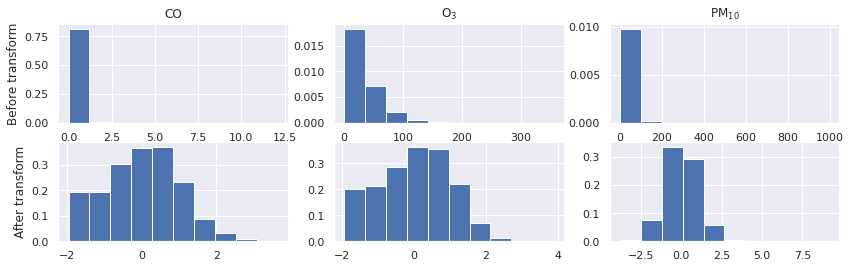

In [54]:
fig, ax = plt.subplots(2,3,figsize = (14,4))
air_data.CO.plot.hist(ax = ax[0][0], density = True, title = 'CO')
air_data.O3.plot.hist(ax = ax[0][1], density = True, title = r'O$_3$')
air_data.PM10.plot.hist(ax = ax[0][2], density = True, title = r'PM$_{10}$')

ax[1][0].hist(transform_air_data[:,-3], density = True)
ax[1][1].hist(transform_air_data[:,-2], density = True)
ax[1][2].hist(transform_air_data[:,-1], density = True)

ax[0][0].set_ylabel("Before transform")
ax[1][0].set_ylabel("After transform")
ax[0][1].set_ylabel("")
ax[0][2].set_ylabel("")

plt.savefig(IMAGES_FOLDER + "before_after_transform_gases.eps", bbox_inches="tight")
plt.show()

In [114]:
air_data[var_continuous] = transform_air_data

### Reconverting int variables

In [126]:
int_var = ["year", "month", "day", "hour", "CodNum", "season"]
air_data[int_var] = air_data[int_var].apply(lambda x: round(x).astype(int))

### ACF and PACF

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

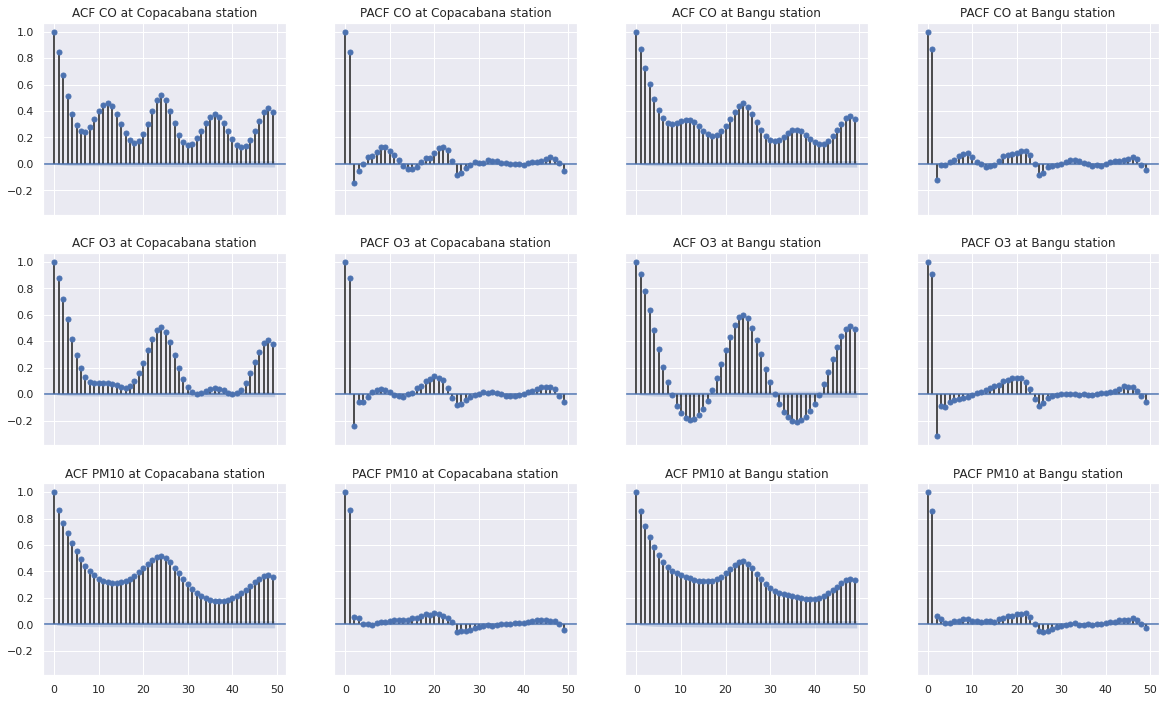

In [56]:
fig, ax = plt.subplots(nrows=3,ncols=4,sharex=True,sharey=True,figsize=(20,12))

# Copacabana and Bangu stations
names = ["Copacabana", "Bangu"]
for i in [1,2]: 
  for e, gas in enumerate(["CO", "O3", "PM10"]):
  
    df = air_data[(air_data.CodNum == i)][gas]
  
    plot_acf(df, ax = ax[e][2*i-2], 
             title = "ACF {} at {} station".format(gas, names[i-1]))
    plot_pacf(df, ax = ax[e][2*i-1],
              title = "PACF {} at {} station".format(gas, names[i-1]))

plt.savefig(IMAGES_FOLDER + "acf_pacf_gases.eps", bbox_inches = "tight")
plt.show()

In [140]:
for gas in ["CO", "O3", "PM10"]:
  for lag in ["1","2","24"]: 
    air_data[gas+"_lag"+lag] = air_data[gas] 

for station in range(1,9):
  for gas in ["CO", "O3", "PM10"]: 
    for lag in [1,2,24]:
      df =  air_data.loc[air_data.CodNum == station, gas+"_lag"+str(lag)].shift(lag)
      air_data.loc[air_data.CodNum == station, gas+"_lag"+str(lag)] = df

air_data.drop(columns=["Data", "hour"], inplace=True)
air_data.dropna(inplace = True)

In [141]:
air_data.to_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv")